In [1]:
# Run only during the first execution of this notebook
!pip install --no-cache-dir --no-build-isolation -U tifffile[all]
# !pip install --no-cache-dir --no-build-isolation torchvision # Run only if you have problems with torchvision using the loaded module from the cluster

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/Arch/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
import time
import datetime
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from torchvision.transforms.functional import InterpolationMode
import tifffile as tiff

def get_mgrid(x_dim, y_dim, z_dim):
    tensors = tuple([torch.linspace(-1, 1, steps=x_dim)] + [torch.linspace(-1, 1, steps=y_dim)] + [torch.linspace(-1, 1, steps=z_dim)])
    grid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    grid = grid.reshape(-1, 3)
    grid = grid[grid[:, 2].argsort()]
    indices = np.lexsort((grid[:, 1], grid[:, 0], grid[:, 2]))
    grid = grid[indices]
    return grid

def get_mgrid_single_slice(x_dim, y_dim, z_slice):
    tensors = tuple([torch.linspace(-1, 1, steps=x_dim)] + [torch.linspace(-1, 1, steps=y_dim)] + [torch.tensor([z_slice])])
    grid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    grid = grid.reshape(-1, 3)
    grid = (grid - 0) / grid.max()
    return grid

class MicroCTVolume(Dataset):
    def __init__(self, base_img_name, start_slice_index, end_slice_index, resize_factor):
        if start_slice_index >= end_slice_index:
            raise Exception("The starting slice index must be before the end slice index.")
        
        self.slices = []
        for slice_img in range(start_slice_index, end_slice_index):
            imgpath = base_img_name + '{:04d}'.format(slice_img) + '.tif'
            img = tiff.imread(imgpath)
            img = img.astype('float32')
            H, W = int(img.shape[0] / resize_factor), int(img.shape[1] / resize_factor)
            transform = Compose([
                ToTensor(),
                Resize((H, W), interpolation=InterpolationMode.BICUBIC),
                Normalize(torch.Tensor([0]), torch.Tensor([img.max()]))
            ])
            img = transform(img)[0]
            self.slices.append(img)
            
        self.slices = torch.stack(self.slices)
        self.coords = get_mgrid(H, W, end_slice_index-start_slice_index)
        self.coords = (self.coords - 0) / self.coords.max()
        self.H, self.W = self.slices[0].shape
        
    def get_H_W(self):
        return self.H, self.W
    
    def get_slice(self):
        return self.slices
        
    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, idx):
        if idx > self.coords.shape[0]:
            raise IndexError("Index out of range")
            
        coords = self.coords[idx]
        
        pixel = self.slices.view(-1,1)[idx]
        
        return pixel, coords


In [6]:
from torch import nn

# SIREN paper: https://arxiv.org/pdf/2006.09661.pdf
# Sine Layer for the SIREN model
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

In [7]:
# SIREN paper: https://arxiv.org/pdf/2006.09661.pdf
# SIREN model with configurable number of layers, hidden features, and outermost linear layer
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, inputs):
        output = torch.sigmoid(self.net(inputs))
        return output, inputs

In [8]:
# A tiny implicit nerual network with ReLU activation function and one input and one output
class ImplicitNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False):
        super().__init__()

        self.net = []
        self.net.append(nn.Linear(in_features, hidden_features, bias=True))
        self.net.append(nn.ReLU())

        for i in range(hidden_layers):
            self.net.append(nn.Linear(hidden_features, hidden_features, bias=True))
            self.net.append(nn.ReLU())

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features, bias=True)
            self.net.append(final_linear)
        else:
            self.net.append(nn.Linear(hidden_features, out_features, bias=True))

        self.net = nn.Sequential(*self.net)

    def A(self, inputs):
        result = self.forward(inputs)[0].cpu()
        return torch.exp(result.T @ result) / (torch.exp(result.T @ result) * (torch.ones(result.shape[0]).T @ torch.ones(result.shape[0])))

    def L(self, inputs):
        A = self.A(inputs)
        t1 = A * torch.ones((inputs.shape[0], inputs.shape[0]))
        t2 = torch.mul(t1, torch.eye(inputs.shape[0]))
        t3 = t2 - A
        return t3
    
    def R(self, inputs):
        inps = inputs.cpu()
        return torch.trace(inps.T @ self.L(inputs) @ inps)
        
    def forward(self, inputs):
        output = torch.sigmoid(self.net(inputs))
        return output, inputs
    
# INRR loss function, paper: https://arxiv.org/abs/2303.15484
def inrr_loss(predictions, input, row_reg_model, col_reg_model, row_reg_coef, col_reg_coef):
    # Calculate the MSE loss
    mse = torch.nn.MSELoss()
    mse = mse(predictions, input)
    
    # Calculate the INRR loss
    row_reg = row_reg_coef * row_reg_model.R(input)
    col_reg = col_reg_coef * col_reg_model.R(input)
    inrr = row_reg + col_reg
    
    return mse + inrr

In [9]:
# Function to train the SIREN model on a single slice/image of the a MicroCT scan using random samples
def train_siren_rand_samples(model, dataloader, total_steps, steps_til_summary, device, checkpoint_path, lr=1e-6,
                                     sampling_frequency=500):
    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()
    
    # Train
    start_time = time.time()
    max_loss = 1.0
    
    # Load data for the first time
    pixels, coords = next(iter(dataloader))
    for step in range(total_steps):

        if ((step+1) % sampling_frequency) == 0:
            # Take random samples again
            pixels, coords = next(iter(dataloader))

        # Move data to GPU
        pixels = pixels.to(device)
        input_coords = coords.to(device)

        # Get Model Prediction
        pred_pixels, _ = model(input_coords)
        loss = loss_fn(pred_pixels, pixels)

        # Optimize
        loss.backward()

        optimizer.step()

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model

# Function to train the SIREN model on a single slice/image of the a MicroCT scan using random samples using INRR technique
def train_siren_rand_samples_inrr(model, row_reg_model, col_reg_model, row_reg_coef, col_reg_coef, dataloader, total_steps, steps_til_summary, device, checkpoint_path, lr=1e-6,
                                     sampling_frequency=500):
    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Define optimizer
    all_params = list(model.parameters()) + list(row_reg_model.parameters()) + list(col_reg_model.parameters())
    optimizer = torch.optim.Adam(lr=lr, params=all_params)
    model.train()
    row_reg_model.train()
    col_reg_model.train()
    model.zero_grad()
    row_reg_model.zero_grad()
    col_reg_model.zero_grad()
    
    # Train
    start_time = time.time()
    max_loss = 1.0
    
    # Load data for the first time
    pixels, coords = next(iter(dataloader))
    for step in range(total_steps):

        if ((step+1) % sampling_frequency) == 0:
            # Take random samples again
            pixels, coords = next(iter(dataloader))

        # Move data to GPU
        pixels = pixels.to(device)
        input_coords = coords.to(device)

        # Get Model Prediction
        pred_pixels, _ = model(input_coords)
        loss = inrr_loss(pred_pixels, pixels, row_reg_model, col_reg_model, row_reg_coef, col_reg_coef)
        loss_mse = torch.nn.MSELoss()(pred_pixels, pixels)

        # Optimize
        loss.backward()

        optimizer.step()

        model.zero_grad()
        row_reg_model.zero_grad()
        col_reg_model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss_mse:.6f}")
            if loss_mse.item() <= max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss_mse.item()
              torch.save(model.state_dict(), checkpoint_path)


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model


# Function to evaluate the input on the SIREN partially in batches
# (useful for when the input does not fit on the GPU completely)
def evaluate_siren_partial(model, height, width, coords, device, batch_size=100, imagepath='pred.png'):
#     H, W = img.squeeze(0).shape
#     img = img.squeeze(0).view(-1, 1)

#     coords = coords.squeeze(0)

    coord_batches = np.array_split(coords, (coords.shape[0] / batch_size))

    img_pred = torch.empty(coords.shape[0], 1)

    i = 0
    for coord_batch in coord_batches:

      # Move input to GPU
      torch.cuda.empty_cache()
      coord_batch = coord_batch.to(device)

      # Get model prediction
      model.eval()
      pred, coord_batch = model(coord_batch)

      img_pred[i:i+len(coord_batch)] = pred.cpu().detach()
      i = i + len(coord_batch)

    # Calculate the loss
#     mse = torch.nn.MSELoss()
#     mse = mse(img_pred, img).item()
#     psnr = 20 * log10(img.max() / sqrt(mse))

    # Show predicted image and ground truth image so far
    model_img = img_pred.view(height,width).numpy()
#     gt_img = img.view(H,W).numpy()

    f, ax = plt.subplots(1,1)
    ax.axis('off')
    ax.set_title('Neural Representation')
    ax.imshow(model_img, cmap="gray")
#     ax[1].axis('off')
#     ax[1].set_title('Original')
#     ax[1].imshow(gt_img, cmap="gray")
    f.show()

    # Save prediction image
    plt.imsave(imagepath, model_img, cmap="gray")

#     print(f'The resulting MSE: {mse:.6f} and PSNR: {psnr}')

    return img_pred

In [8]:
# Create a MicroCTVolume instance
start_slice = 1390
end_slice = 1399
volume = MicroCTVolume(base_img_name='./dataset/174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-1', resize_factor=10, start_slice_index=start_slice, end_slice_index=end_slice)

# Create a DataLoader to iterate over the samples
random_samples = 20000
dataloader = DataLoader(volume, batch_size=random_samples, shuffle=True)

/cephyr/users/amirmaso/Alvis/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
from torchvision.utils import make_grid

# Import model (Use w0 and w_h of 30)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=30, hidden_omega_0=30.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp.pt')

Step 0, Total loss 0.010829
Best new model! Saving...
Step 100, Total loss 0.001180
Best new model! Saving...
Step 200, Total loss 0.001113
Best new model! Saving...
Step 300, Total loss 0.001053
Best new model! Saving...
Step 400, Total loss 0.000987
Best new model! Saving...
Step 500, Total loss 0.000885
Best new model! Saving...
Step 600, Total loss 0.000801
Best new model! Saving...
Step 700, Total loss 0.000650
Best new model! Saving...
Step 800, Total loss 0.000534
Best new model! Saving...
Step 900, Total loss 0.000384
Best new model! Saving...
Step 1000, Total loss 0.000287
Best new model! Saving...
Step 1100, Total loss 0.000210
Best new model! Saving...
Step 1200, Total loss 0.000171
Best new model! Saving...
Step 1300, Total loss 0.000141
Best new model! Saving...
Step 1400, Total loss 0.000115
Best new model! Saving...
Step 1500, Total loss 0.000092
Best new model! Saving...
Step 1600, Total loss 0.000091
Best new model! Saving...
Step 1700, Total loss 0.000073
Best new mod

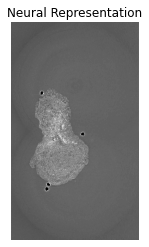

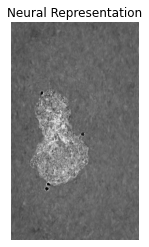

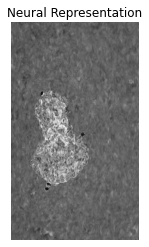

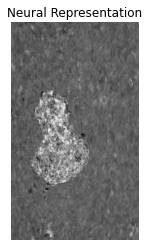

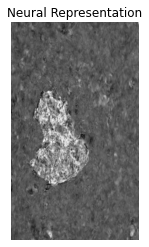

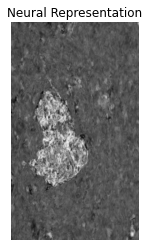

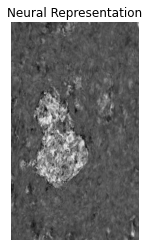

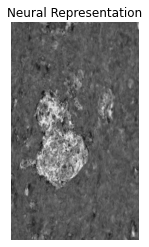

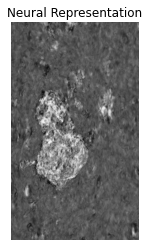

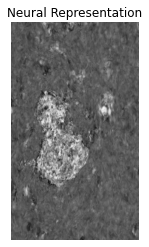

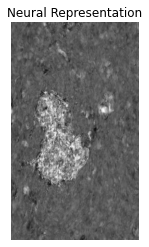

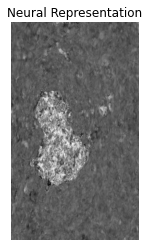

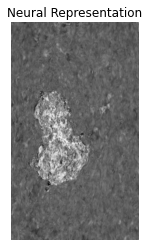

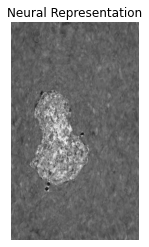

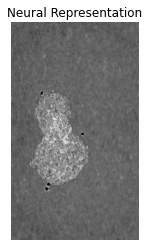

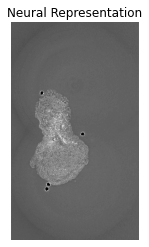

In [36]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [37]:
# Import model (Use w0 and w_h of 10)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=10, hidden_omega_0=10.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp_1.pt')

Step 0, Total loss 0.012577
Best new model! Saving...
Step 100, Total loss 0.001356
Best new model! Saving...
Step 200, Total loss 0.001321
Best new model! Saving...
Step 300, Total loss 0.001299
Best new model! Saving...
Step 400, Total loss 0.001277
Best new model! Saving...
Step 500, Total loss 0.001254
Best new model! Saving...
Step 600, Total loss 0.001233
Best new model! Saving...
Step 700, Total loss 0.001215
Best new model! Saving...
Step 800, Total loss 0.001198
Best new model! Saving...
Step 900, Total loss 0.001180
Best new model! Saving...
Step 1000, Total loss 0.001160
Best new model! Saving...
Step 1100, Total loss 0.001137
Best new model! Saving...
Step 1200, Total loss 0.001104
Best new model! Saving...
Step 1300, Total loss 0.001074
Best new model! Saving...
Step 1400, Total loss 0.001045
Best new model! Saving...
Step 1500, Total loss 0.001025
Best new model! Saving...
Step 1600, Total loss 0.000997
Best new model! Saving...
Step 1700, Total loss 0.000978
Best new mod

In [ ]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp_1.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=10, hidden_omega_0=10.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [ ]:
# Import model (Use w0 and w_h of 50)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=50, hidden_omega_0=50.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp_2.pt')

In [ ]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp_2.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=50, hidden_omega_0=50.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [ ]:
# Import model (Use w0 and w_h of 5)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=5, hidden_omega_0=5.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp_3.pt')

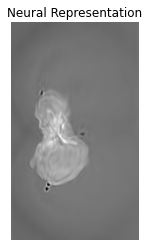

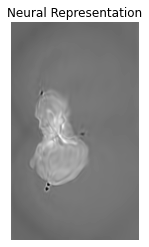

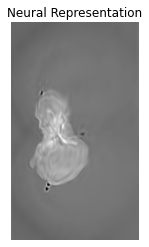

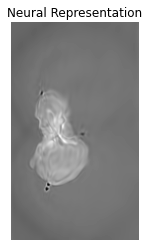

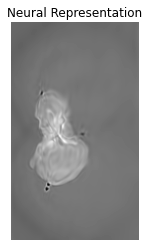

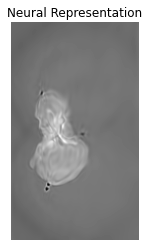

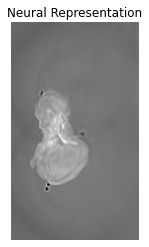

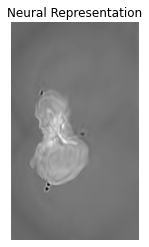

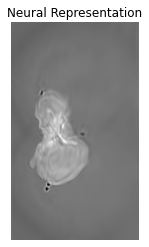

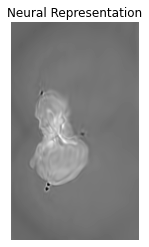

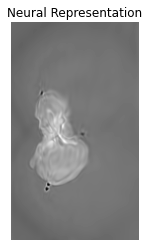

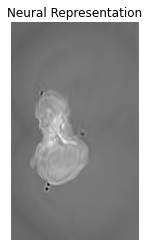

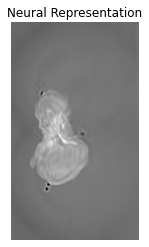

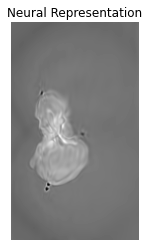

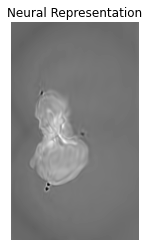

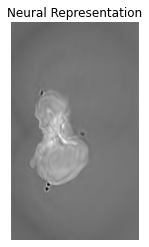

In [9]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp_3.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=5, hidden_omega_0=5.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [ ]:
# Import model (Use w0 and w_h of 7)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=7, hidden_omega_0=7.)
row_reg_model = ImplicitNet(in_features=1, hidden_features=100, hidden_layers=2, out_features=1, outermost_linear=True)
col_reg_model = ImplicitNet(in_features=1, hidden_features=100, hidden_layers=2, out_features=1, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
row_reg_model.to(device)
col_reg_model.to(device)

torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples_inrr(model, row_reg_model, col_reg_model, 10, 10, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp_inrr.pt')

/local/tmp.1565571/ipykernel_884922/4283938535.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2314.)
  return torch.exp(result.T @ result) / (torch.exp(result.T @ result) * (torch.ones(result.shape[0]).T @ torch.ones(result.shape[0])))


Step 0, Total loss 0.014720
Best new model! Saving...
Step 100, Total loss 0.001308
Best new model! Saving...
Step 200, Total loss 0.001236
Best new model! Saving...


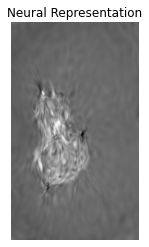

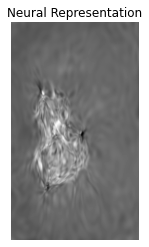

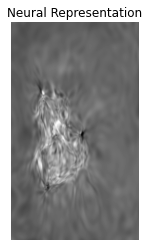

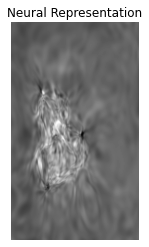

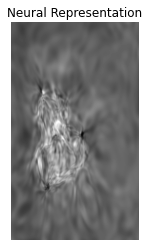

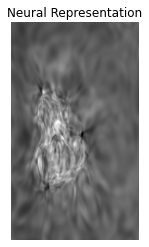

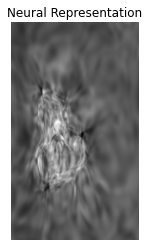

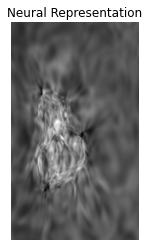

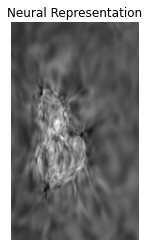

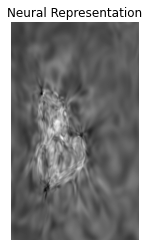

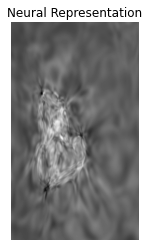

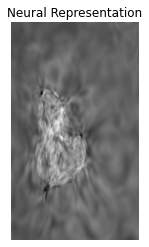

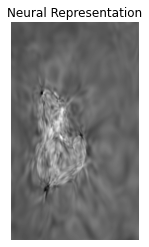

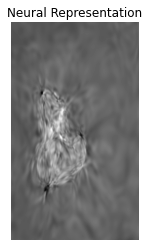

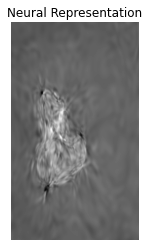

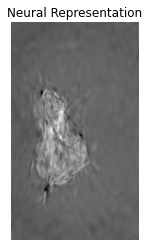

In [10]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp_inrr.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=7, hidden_omega_0=7.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [9]:
# Import model (Use w0 and w_h of 5)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=5, hidden_omega_0=5.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=5000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_rand_samp_4.pt')

Step 0, Total loss 0.009057
Best new model! Saving...
Step 100, Total loss 0.001578
Best new model! Saving...
Step 200, Total loss 0.001500
Best new model! Saving...
Step 300, Total loss 0.001451
Best new model! Saving...
Step 400, Total loss 0.001408
Best new model! Saving...
Step 500, Total loss 0.001465
Step 600, Total loss 0.001302
Best new model! Saving...
Step 700, Total loss 0.001259
Best new model! Saving...
Step 800, Total loss 0.001223
Best new model! Saving...
Step 900, Total loss 0.001187
Best new model! Saving...
Step 1000, Total loss 0.001475
Step 1100, Total loss 0.001169
Best new model! Saving...
Step 1200, Total loss 0.001088
Best new model! Saving...
Step 1300, Total loss 0.001018
Best new model! Saving...
Step 1400, Total loss 0.000951
Best new model! Saving...
Step 1500, Total loss 0.001460
Step 1600, Total loss 0.000907
Best new model! Saving...
Step 1700, Total loss 0.000795
Best new model! Saving...
Step 1800, Total loss 0.000703
Best new model! Saving...
Step 19

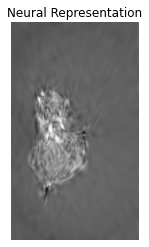

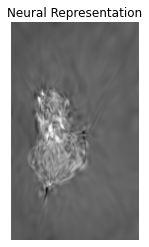

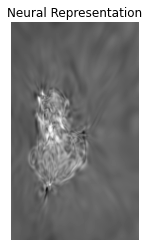

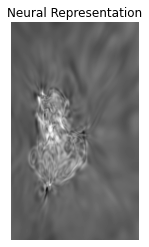

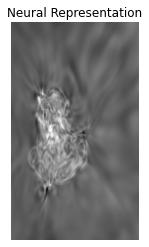

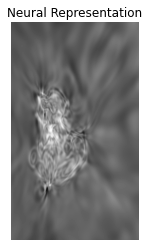

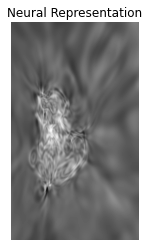

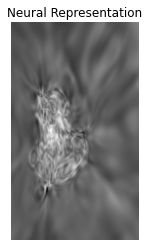

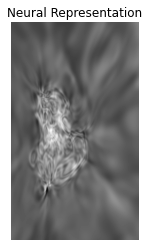

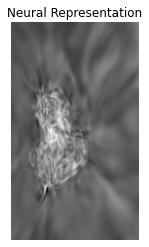

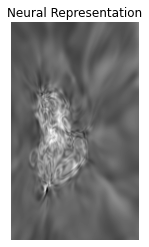

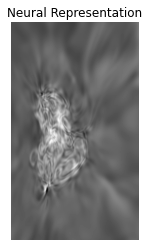

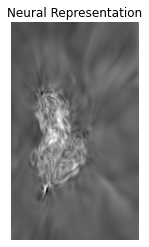

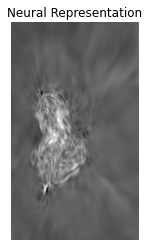

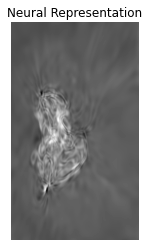

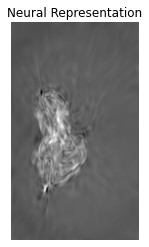

In [10]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_rand_samp_4.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=5, hidden_omega_0=5.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

H, W = volume.get_H_W()

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=100, imagepath='pred3D.png')

In [15]:
# Import model (Use w0 and w_h of 10)
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=13, hidden_omega_0=13.)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Create a MicroCTVolume instance
start_slice = 1390
end_slice = 1399
volume = MicroCTVolume(base_img_name='./dataset/pp_174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-1', resize_factor=5, start_slice_index=start_slice, end_slice_index=end_slice)

# Create a DataLoader to iterate over the samples
random_samples = 30000
dataloader = DataLoader(volume, batch_size=random_samples, shuffle=True)

# Train model
model = train_siren_rand_samples(model, dataloader, sampling_frequency=500, total_steps=20000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{start_slice}_{end_slice}_checkpoint_preprocessed_images.pt')

Step 0, Total loss 0.173007
Best new model! Saving...
Step 100, Total loss 0.005233
Best new model! Saving...
Step 200, Total loss 0.003759
Best new model! Saving...
Step 300, Total loss 0.002837
Best new model! Saving...
Step 400, Total loss 0.002131
Best new model! Saving...
Step 500, Total loss 0.005553
Step 600, Total loss 0.001404
Best new model! Saving...
Step 700, Total loss 0.000855
Best new model! Saving...
Step 800, Total loss 0.000555
Best new model! Saving...
Step 900, Total loss 0.000374
Best new model! Saving...
Step 1000, Total loss 0.006867
Step 1100, Total loss 0.000419
Step 1200, Total loss 0.000218
Best new model! Saving...
Step 1300, Total loss 0.000125
Best new model! Saving...
Step 1400, Total loss 0.000086
Best new model! Saving...
Step 1500, Total loss 0.006644
Step 1600, Total loss 0.000196
Step 1700, Total loss 0.000074
Best new model! Saving...
Step 1800, Total loss 0.000061
Best new model! Saving...
Step 1900, Total loss 0.000031
Best new model! Saving...
St

2088 2088


KeyboardInterrupt: 

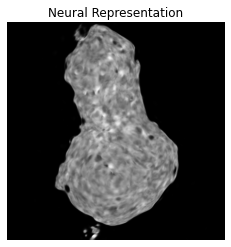

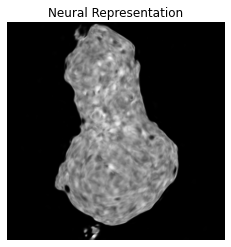

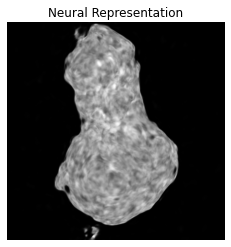

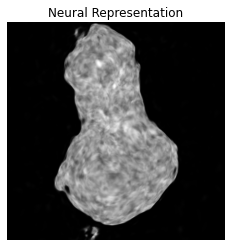

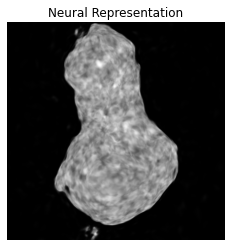

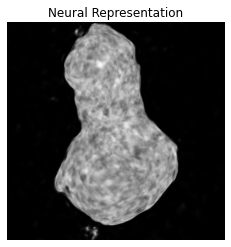

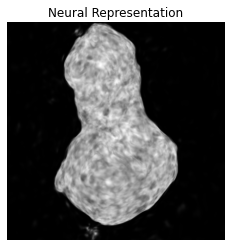

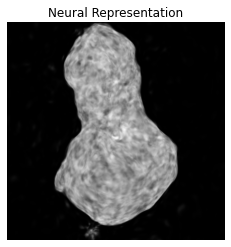

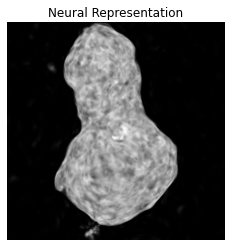

In [16]:
# Evaluate model for a given z slice

# Load trained model from checkpoint for evaluation
PATH = "1390_1399_checkpoint_preprocessed_images.pt"
model = Siren(in_features=3, out_features=1, hidden_features=500, hidden_layers=4, outermost_linear=True, first_omega_0=13, hidden_omega_0=13.)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

start_slice = 1390
end_slice = 1399
volume = MicroCTVolume(base_img_name='./dataset/pp_174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-1', resize_factor=1, start_slice_index=start_slice, end_slice_index=end_slice)
H, W = volume.get_H_W()

print(H, W)

start = -0.75
end = -0.5
interval = 15.0
step = (end-start)/interval
for z_slice in np.arange(start, end+step, step):
    coords = get_mgrid_single_slice(H, W, float(z_slice))

    evaluate_siren_partial(model, H, W, coords, device, batch_size=500, imagepath=f'pred_{z_slice}.png')
